# IMPORT ALL THE NECCESSARY PACKAGES

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.stats import uniform
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer 

# LOADING THE DATA

Here we are going to load all the necessary data for our analysis and prediction.

In [2]:
# Load the training data
data_train = pd.read_csv('train.csv')
# Load the test data
data_test = pd.read_csv('test.csv')
data = data_train.append(data_test , ignore_index = True, sort=False)
# Because of that the SalePrice data is skewed we are working with logharithm
# Later all the predictions will be transformed to the ordinary scale
data.SalePrice = np.log(data.SalePrice)
# Load predictions obtained with stacking method
# https://www.kaggle.com/itslek/blend-stack-lr-gb-0-10649-house-prices-v57
stack_pred = pd.read_csv('stack.csv') 
# divide the data into numerical ("numeric") features
numeric = list( data_test.loc[:,data_test.dtypes != 'object'].drop('Id',axis=1).columns.values )
# divide the data into categorical ("category") features
category = list( data_test.loc[:,data_test.dtypes == 'object'].columns.values )

# DATA PREPROCESSING

### MISSING VALUE IMPUTATION

In [3]:
# In this list we store all the features which MVs will be fill with 'NA' for categorical features
na = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageCond','GarageQual','GarageFinish','GarageType','BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1']
# In this list we store all the features which MVs will be fill with 0
# We assume that the MVs values for these features mean the lack of that feature in the house
zero = ['GarageYrBlt','MasVnrArea','BsmtHalfBath','BsmtFullBath','GarageArea','GarageCars','TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']
# In this list we store all the features which MVs will be fill with the most frequent value for that feature
# We assume that these features existis for all houses but are missed in some cases
mode = ['Functional','Utilities','Exterior1st','SaleType','KitchenQual','Electrical']
# Filling MVs
for i in zero: data[i].fillna(0, inplace=True)
for i in na: data[i].fillna('NA', inplace=True)
for i in mode: data[i].fillna(data[i].mode()[0], inplace=True)

data['LotFrontage'].fillna(data.LotFrontage.median(), inplace=True)
data['MasVnrType'].fillna('None', inplace=True)
data['Exterior2nd'].fillna('None', inplace=True)
# We assume that Zoning and Neiborhood data are dependent on each other
# So for each MSzoning we set as a value the most frequent value of Neighborhood
data = data.rename({'Neighborhood':'N', 'MSZoning':'M'}, axis='columns')
for i in data['N'].unique():
    if data['M'][data['N'] == i].isnull().sum() > 0:
        data.loc[data['N'] == i,'M'] = data.loc[data['N'] == i,'M'].fillna(data.loc[data['N'] == i,'M'].mode()[0])
data = data.rename({'N':'Neighborhood', 'M':'MSZoning'}, axis='columns')

### FEATURE CONVERTING 

In [4]:
# The values of these qualitative features couled be ranked so we change the values according their ranking 
Alley = {'NA':0, 'Grvl':1, 'Pave':2}
BsmtCond = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
BsmtExposure = {'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
BsmtFinType1 = {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
BsmtFinType2 = {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
BsmtQual = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
ExterCond = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
ExterQual = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
FireplaceQu = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
Functional = {'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}
GarageCond = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
GarageQual = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
HeatingQC = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
KitchenQual = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
LandSlope = {'Sev':1, 'Mod':2, 'Gtl':3}
PavedDrive = {'N':1, 'P':2, 'Y':3}
PoolQC = {'NA':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
Street = {'Grvl':1, 'Pave':2}
Utilities = {'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}

dict = {'Alley':Alley,'BsmtCond':BsmtCond,'BsmtExposure':BsmtExposure ,'BsmtFinType1':BsmtFinType1,'BsmtFinType2':BsmtFinType2,'BsmtQual':BsmtQual,'ExterCond':ExterCond,'ExterQual':ExterQual,'FireplaceQu':FireplaceQu,'Functional':Functional,'GarageCond':GarageCond,'GarageQual':GarageQual,'HeatingQC':HeatingQC,'KitchenQual':KitchenQual,'LandSlope':LandSlope,'PavedDrive':PavedDrive,'PoolQC':PoolQC,'Street':Street,'Utilities':Utilities}
data = data.replace(dict)

In [5]:
# update the list of numeric features
newnumeric = ['Alley','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual', 'ExterCond','ExterQual','FireplaceQu','Functional','GarageCond','GarageQual','HeatingQC','KitchenQual','LandSlope','PavedDrive','PoolQC','Street','Utilities']
numeric = numeric + newnumeric
# update the list of categorical features
category = [i for i in category if i not in numeric]
data=data.drop('MoSold',axis=1)
tmp ={20:'class1', 30:'class2', 40:'class3', 45:'class4', 50:'class5', 60:'class6', 70:'class7', 75:'class8', 80:'class9', 85:'class10', 90:'class11', 120:'class12', 150:'class13', 160:'class14', 180:'class15', 190:'class16'}
data = data.replace({'MSSubClass':tmp}) # convert this feature to categorical
numeric.remove('MSSubClass')
category.append('MSSubClass')
numeric.remove('MoSold') # this feature is redundant

### CREATE NEW FEATURES

In [6]:
data['numYr'] = data.YrSold - data.YearBuilt # a new feature which indicates how old is the building
data['numYrRemod'] = data.YrSold - data.YearRemodAdd # a new feature which indicates how many years ago building was remodeled
data['numYrGarage'] = data.YrSold - data.GarageYrBlt # a new feature which indicates how old is the garage
mx = max(data['numYrGarage'][data['numYrGarage'] < 1000])  
data['numYrGarage'].clip(upper = mx, inplace=True) # set upper bound for garage years
data['numYr'].clip_lower(0, inplace=True) # set lower bound for garage years
data['numYrRemod'].clip_lower(0, inplace=True) # set lower bound for garage years
data['numYrGarage'].clip_lower(0, inplace=True) # set lower bound for garage years
data.drop(['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt'],axis=1, inplace=True)
numeric = [x for x in numeric if x not in ['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt']]+['numYr','numYrRemod','numYrGarage']

### REMOVE OUTLIERS

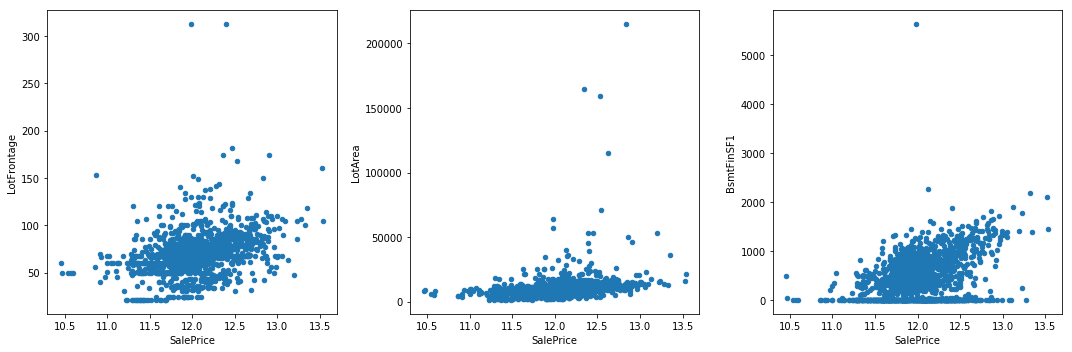

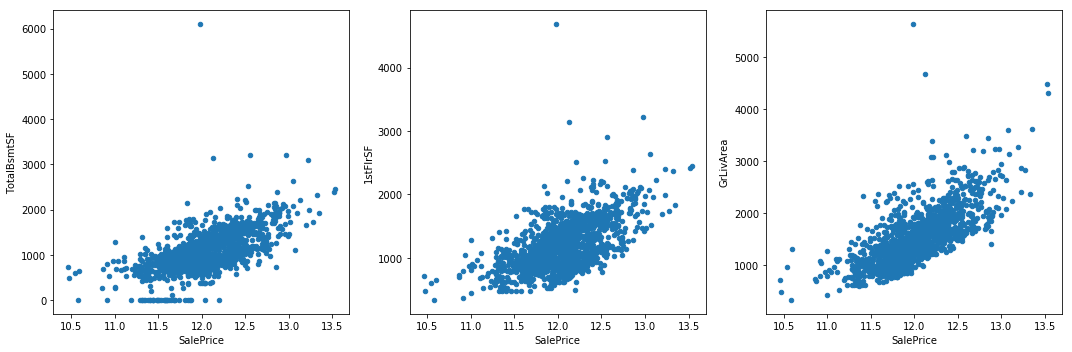

In [7]:
# Let`s check if there is some data to be cleaned as outlier
fig, axs = plt.subplots(1,3)
for cnt,i in enumerate(['LotFrontage', 'LotArea', 'BsmtFinSF1']):
    data.plot(x='SalePrice',y=i, kind = 'scatter', ax=axs[cnt%3], figsize=(15,5))
    plt.tight_layout()
fig, axs = plt.subplots(1,3)
for cnt,i in enumerate(['TotalBsmtSF', '1stFlrSF', 'GrLivArea']):
    data.plot(x='SalePrice',y=i, kind = 'scatter', ax=axs[cnt%3], figsize=(15,5))
    plt.tight_layout()

In [8]:
# Removing outliers
outliers = pd.concat([
data[data['LotFrontage'] > 300],
data[data['LotArea'] > 100000],
data[data['BsmtFinSF1'] > 4000],
data[data['TotalBsmtSF'] > 6000],
data[data['1stFlrSF'] > 4000],
data[((data['GrLivArea'] > 4000) & (data['SalePrice'] < 13))]]).index
data = data.drop(set(outliers[outliers < 1460])).reset_index(drop=True)

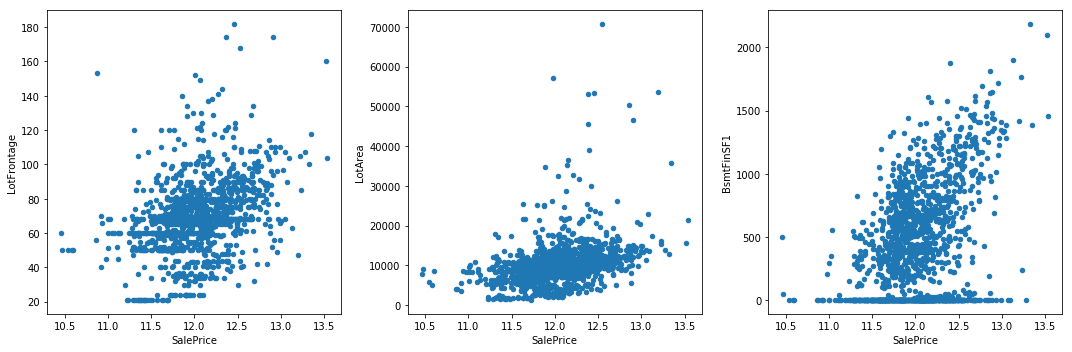

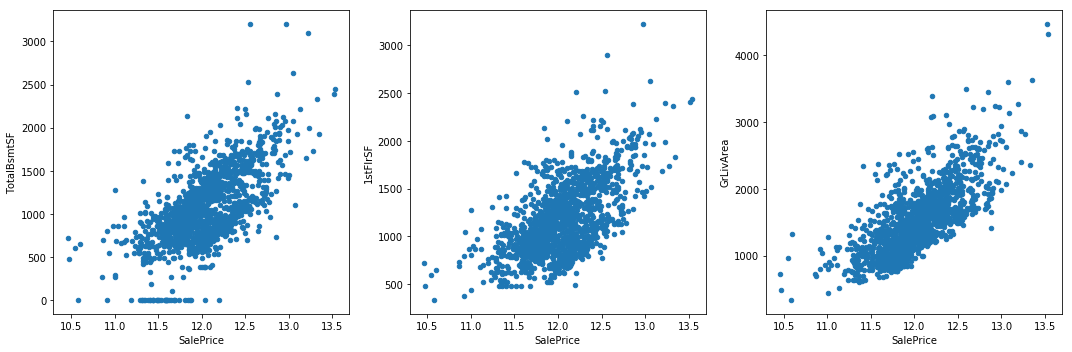

In [9]:
# Let`s check how this action affected the data
fig, axs = plt.subplots(1,3)
for cnt,i in enumerate(['LotFrontage', 'LotArea', 'BsmtFinSF1']):
    data.plot(x='SalePrice',y=i, kind = 'scatter', ax=axs[cnt%3], figsize=(15,5))
    plt.tight_layout()
fig, axs = plt.subplots(1,3)
for cnt,i in enumerate(['TotalBsmtSF', '1stFlrSF', 'GrLivArea']):
    data.plot(x='SalePrice',y=i, kind = 'scatter', ax=axs[cnt%3], figsize=(15,5))
    plt.tight_layout()

### FEATURE TRANSFORMATION

In [10]:
# We transform features which absolute value of the skeweness is greater than 0.5
sk_feat = np.array(numeric)[np.abs(skew(data[numeric])) > 0.5] # define the skeweness
data[sk_feat] = np.log1p(data[sk_feat]) # transform the data

In [11]:
# we should also escape dummy variables trap
trap = [] # this is the list of dummy vars which is going to be delete 
for i in category: trap += [i+'_'+str(data[i].unique()[-1])] # fill the list
data = pd.get_dummies(data,columns=category).drop(trap,axis=1) # drop the unnecessary columns

In [12]:
X_tr  = data[:-1459].drop(['SalePrice','Id'], axis=1)
y_tr  = data[:-1459]['SalePrice']
X_ts  = data[-1459:].drop(['SalePrice','Id'], axis=1)

# fit the training set only, then transform both the training and test sets
scaler = RobustScaler()
X_tr[numeric]= scaler.fit_transform(X_tr[numeric])
X_ts[numeric]= scaler.transform(X_ts[numeric])

### FEATURE SELECTION

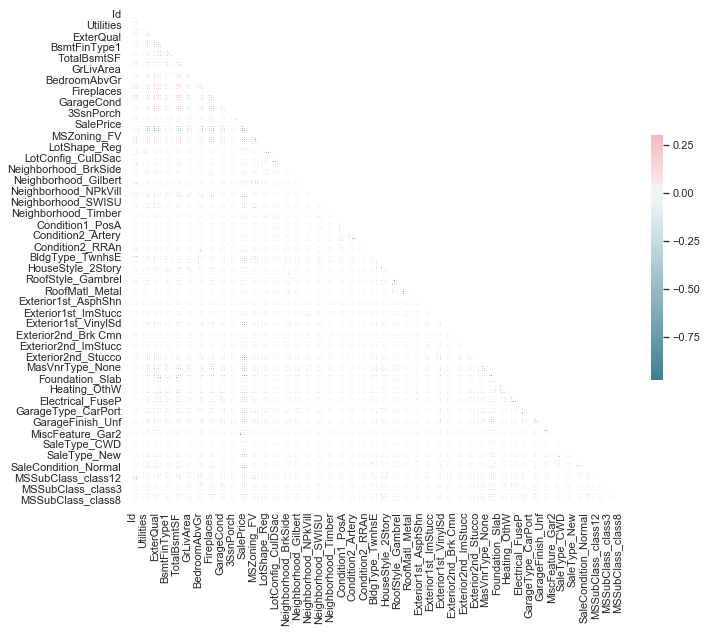

In [13]:
# Let` plot correlation matrix
sns.set(style="white")
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,  square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [14]:
# Let`s evalute the importance of the features using XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_tr, y_tr)
imp = pd.DataFrame(xgb.feature_importances_ ,columns = ['Score'],index = X_tr.columns)
imp = imp.sort_values(['Score'], ascending = False)

In [15]:
feat_imp = list(imp[imp.Score > 0.005].index) # Keep only the features with the importance score more than 0.005
X_tr = X_tr[feat_imp]
X_ts = X_ts[feat_imp]

# MODELLING

In [16]:
# Here we are going to fit Kernel Ridge model to our data
# Sometimes it could happen that the RandomizedSearchCV hangs (execution last forever)
# This could be fixed by setting n_jobs equal to 1
def nrmse(real, pred):  return -1.0*np.sqrt(np.mean((real-pred)**2)) # defining the error function
params = {'alpha': uniform(0.05, 1.0), 'kernel': ['polynomial'], 'degree': [2], 'coef0':uniform(0.5, 3.5)}
r_s = RandomizedSearchCV(estimator = KernelRidge(), param_distributions = params, n_iter = 1000, cv = 3, scoring = make_scorer(nrmse), n_jobs = 1, random_state=0)
r_s = r_s.fit(X_tr, y_tr)
model = r_s.best_estimator_

In [17]:
# Here are going to predict SalePrice with trained Kernel Ridge model  
# Let`s predict values with trained model
ridge_pred = np.exp(model.predict(X_ts)) # prediction based on kernel ridge method
final_pred = 2/(1/ridge_pred + 1/stack_pred.SalePrice) # harmonic mean of the results (with predcition based on stacking method)
output = pd.DataFrame({'Id': data_test['Id'], 'SalePrice': final_pred})
output.to_csv('final_prediction.csv', index=False)